# C. elegans live/dead assay Dataset

- Dataset [BBBC010](https://data.broadinstitute.org/bbbc/BBBC010/) available from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/index.html) ([Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083)).

In [1]:
%matplotlib inline

import os
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm
from PIL import Image
import shutil
import matplotlib.pyplot as plt
from skimage import exposure

import sys; sys.path.append("../../../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/C_elegans")

data_dir = root_dir / "Data"
data_dir.mkdir(parents=True, exist_ok=True)

config = maskflow.config.load_config("config.yaml")

# Copy config next to data folder
maskflow.config.save_config(config, root_dir / "config.yaml")

## Download Dataset

In [2]:
images_url = "https://data.broadinstitute.org/bbbc/BBBC010/BBBC010_v1_images.zip"
annotations_url = "https://data.broadinstitute.org/bbbc/BBBC010/BBBC010_v1_foreground_eachworm.zip"

# Download and exctract dataset in user data dir
images_path = maskflow.archive.open_archive(images_url, appname="maskflow", progressbar=True, erase=False)
images_path = images_path.iterdir().__next__()
annotations_path = maskflow.archive.open_archive(annotations_url, appname="maskflow", progressbar=True, erase=False)
annotations_path = annotations_path.iterdir().__next__()

63.6MB [00:10, 6.66MB/s]                            
2.61MB [00:00, 3.31MB/s]                            


## Build the dataset

In [3]:
training_size = 0.8  # From 0 to 1
png_compression_level = 0  # From 0 to 9

images_paths = list(images_path.glob("*_w2_*"))
len_dataset = len(images_paths)

train_ids, _ = train_test_split(np.arange(0, len_dataset), train_size=training_size)

train_dir = data_dir / "train_dataset"
train_dir.mkdir(parents=True, exist_ok=True)

test_dir = data_dir / "test_dataset"
test_dir.mkdir(parents=True, exist_ok=True)

train_annotations_path = data_dir / "train_annotations.json"
test_annotations_path = data_dir / "test_annotations.json"

train_annotations = maskflow.dataset.get_base_annotations(config['CLASS_NAMES'], supercategory="worm")
test_annotations = maskflow.dataset.get_base_annotations(config['CLASS_NAMES'], supercategory="worm")

for image_id, fname in tqdm.tqdm_notebook(enumerate(images_paths), total=len(images_paths)):
    
    well_location = fname.stem.split('_')[-3]
    well_column = int(well_location[1:])
     
    image = np.array(Image.open(fname))    
    image = exposure.rescale_intensity(image, out_range='uint8')
    image = image.astype("uint8")
    image = np.expand_dims(image, axis=-1)
    image = np.tile(image, [1, 1, 3])
    
    masks = []
    for mask_path in annotations_path.glob(f'{well_location}*.png'):
        mask = np.array(Image.open(mask_path))
        masks.append(mask)
    masks = np.array(masks)
    
    # Manual crop to make the dataset smaller
    image = image[50:450, 150:550]
    masks = masks[:, 50:450, 150:550]
        
    # We check masks are not empty
    to_keep = np.where(masks.sum(-1).sum(-1) > 0)[0]
    masks = masks[to_keep]
    
    if masks.shape[0] == 0:
        print("Discard fname")
        continue
        
    if well_column <= 12:
        label_name = 'worm_alive'
    else:
        label_name = 'worm_dead'
    class_ids = np.repeat(config['CLASS_NAMES'].index(label_name) + 1, masks.shape[0])
    class_ids = class_ids.astype('uint32')
    
    basename = f"worm_{well_location}_{image_id:04d}.png"
    
    # Get the annotation in the COCO format.
    image_info, image_annotations = maskflow.dataset.get_annotations(image_id, basename, image, masks, class_ids)
    
    if image_id in train_ids:
        image_path = train_dir / basename
        train_annotations["images"].append(image_info)
        train_annotations["annotations"].extend(image_annotations)
    else:
        image_path = test_dir / basename
        test_annotations["images"].append(image_info)
        test_annotations["annotations"].extend(image_annotations)
    
    Image.fromarray(image).save(str(image_path), compress_level=png_compression_level)
    
maskflow.dataset.save_annotations(train_annotations, train_annotations_path)
maskflow.dataset.save_annotations(test_annotations, test_annotations_path)

/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
# Cleanup Raw Data
import shutil
shutil.rmtree(images_path.parent)
shutil.rmtree(annotations_path.parent)

## Check the dataset

2018-11-09 11:39:54,633:WARNING:maskrcnn_benchmark.data.build: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


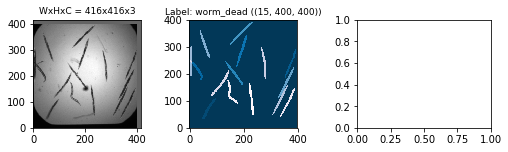

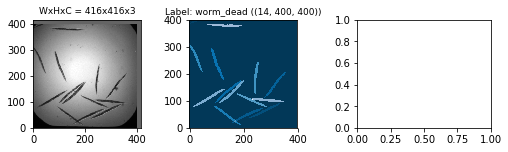

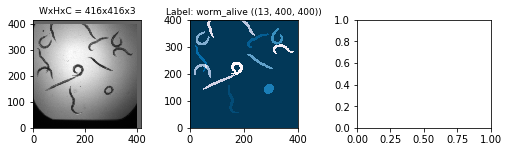

In [7]:
config['SOLVER']['IMS_PER_BATCH'] = 3
config['TEST']['IMS_PER_BATCH'] = 3

# Number of batch to load
n = 1

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=True)
some_data = [iter(data_loader).next() for _ in range(n)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

for batch_image, batch_target, batch_idx in some_data:
    maskflow.viz.batch_display_top_masks(batch_image, batch_target, batch_idx, categories,
                                         basesize=7, limit=2, cmap="PuBu_r",
                                         pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                         pixel_std=config['INPUT']['PIXEL_STD'])